<a href="https://colab.research.google.com/github/harishmuh/Deep-Learning_study/blob/main/Brain_Tumour_Multiclassclassification_CNN_with_TF_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor - Multiclass classification using CNN**

In this project, we will build deeplearning CNN model with keras to classify  brain tumours from MRI photographs.

## **Initial setup**

**Settings credentials**

In [4]:
# Install kaggle
!pip install --quiet kaggle

In [5]:
# Request Kaggle credentials from user (Use of getpass: API key won't be visible) ---
from getpass import getpass
import os, json

print("🔐 Enter your Kaggle credentials")
username = input("Kaggle username: ")
key = getpass("Kaggle API key (hidden): ")

# --- 3. Export as environment variables ---
os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY'] = key

🔐 Enter your Kaggle credentials
Kaggle username: harishmuhammad
Kaggle API key (hidden): ··········


In [6]:
# Export as environment variables
os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY'] = key

**Creating kaggle.json file to configue API**

In [7]:
# Creating kaggle.json file
kaggle_dir = "/root/.kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
with open(kaggle_json_path, "w") as f:
    json.dump({"username": username, "key": key}, f)

# Correct permissions
!chmod 600 /root/.kaggle/kaggle.json

print("\n✅ Kaggle API is configured.")


✅ Kaggle API is configured.


**Selecting brain tumor classification dataset**

In [8]:
# Displaying the list to download
!kaggle datasets list -s 'Brain Tumor Classification (MRI)'

ref                                                          title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
sartajbhuvaji/brain-tumor-classification-mri                 Brain Tumor Classification (MRI)                       91002358  2025-08-12 15:45:16.840000          91783        800  0.875            
jarvisgroot/brain-tumor-classification-mri-images            Brain Tumor Classification MRI Images                 663261631  2021-07-04 21:21:38.660000           2161         45  0.9375           
orvile/brain-cancer-mri-dataset                              Brain Cancer - MRI dataset                            151455223  2025-04-01 11:29:32.163000           5699         76  1.0              
masoudnick

In [9]:
!kaggle datasets download -d 'sartajbhuvaji/brain-tumor-classification-mri'

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 971MB/s]


**Extracting and preparing path for the downloaded files**

In [11]:
import zipfile, os, shutil

# Extracting the downloaded zip file and placing into datasets folders
filezip = zipfile.ZipFile('/content/brain-tumor-classification-mri.zip')
filezip.extractall('datasets')

In [13]:
# Displaying items inside directory
os.listdir('datasets')

['Training', 'Testing']

**Importing required libraries**

In [14]:
# Importing libraries

# default libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# tensorflow and computer vision
import cv2 # displaying images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Creating more variations for the data - reducing overfitting
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# scikit-learn
from sklearn.utils import shuffle # shuffling data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Others
from tqdm import tqdm
import ipywidgets as widgets
import io
import os
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
filterwarnings('ignore')

In [16]:
# Displaying files inside the datasets folder
for dirname, _, filenames in os.walk('datasets'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

datasets/Training/meningioma_tumor/m2 (171).jpg
datasets/Training/meningioma_tumor/m2 (88).jpg
datasets/Training/meningioma_tumor/m (47).jpg
datasets/Training/meningioma_tumor/m3 (15).jpg
datasets/Training/meningioma_tumor/m (162).jpg
datasets/Training/meningioma_tumor/m2 (76).jpg
datasets/Training/meningioma_tumor/m (129).jpg
datasets/Training/meningioma_tumor/m1(36).jpg
datasets/Training/meningioma_tumor/m3 (48).jpg
datasets/Training/meningioma_tumor/m1(42).jpg
datasets/Training/meningioma_tumor/m2 (94).jpg
datasets/Training/meningioma_tumor/m (106).jpg
datasets/Training/meningioma_tumor/m (170).jpg
datasets/Training/meningioma_tumor/m3 (221).jpg
datasets/Training/meningioma_tumor/m3 (218).jpg
datasets/Training/meningioma_tumor/m1(141).jpg
datasets/Training/meningioma_tumor/m1(48).jpg
datasets/Training/meningioma_tumor/m3 (129).jpg
datasets/Training/meningioma_tumor/m2 (111).jpg
datasets/Training/meningioma_tumor/m1(193).jpg
datasets/Training/meningioma_tumor/m1(156).jpg
datasets/Tra

## **Data Prepocessing**

**Setting labels**

In [17]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
labels[0] # check

'glioma_tumor'

In [19]:
# Incorporating data with label
X_train = []
y_train = []
image_size = 150 # resize image for faster training
for i in labels:
  folderPath = os.path.join('datasets', 'Training', i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath, j))
    img = cv2.resize(img, (image_size, image_size))
    X_train.append(img)
    y_train.append(i)

for i in labels:
  folderPath = os.path.join('datasets', 'Testing', i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath, j))
    img = cv2.resize(img, (image_size, image_size))
    X_train.append(img)
    y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 283.36it/s]


**Displaying sample images**

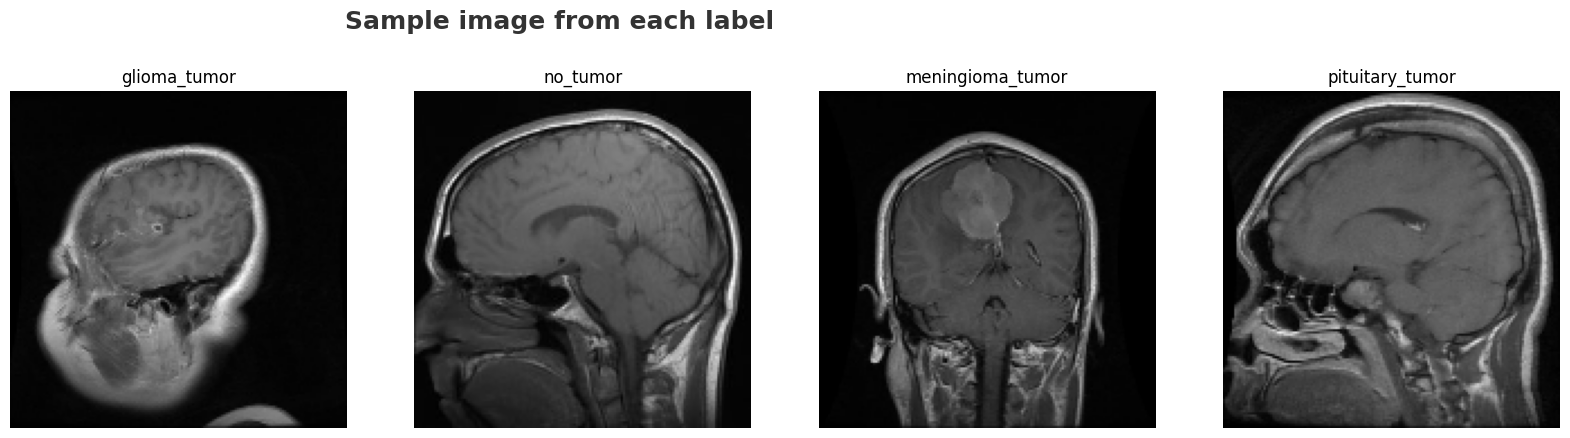

In [23]:
# Displaying sample images
k = 0
fig, ax = plt.subplots(1,4, figsize=(20,20))
fig.suptitle('Sample image from each label', size=18, fontweight='bold', y=0.62, x=0.4, alpha=0.8)

for i in labels:
  j=0
  while True:
    if y_train[j] == i:
      ax[k].imshow(X_train[j])
      ax[k].set_title(y_train[j])
      ax[k].axis('off')
      k+=1
      break
    j+=1

**Shuffling**

In [24]:
# Shuffling
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [27]:
# shape
print(X_train.shape)

(3264, 150, 150, 3)


**Adding variations**

In [28]:
# Creating variations with ImageDataGenerator
# Reduce the risk of overfitting
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)
X_train.shape

(3264, 150, 150, 3)

**Data splitting**

In [29]:
# Data splitting # 90 training set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

In [30]:
# Converting labels to categorical
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## **Model Building**

In [31]:
# Applying 'imagenet' for adjusting weights and improving model training

effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
# Designing model architecture
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model) # Dense 4: 4 classes, softmax: multiclass classification
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [33]:
# Model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

## **Training data**

**Compiling model**

In [38]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Settings parameters**

In [39]:
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("effnet.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

**Model training**

In [40]:
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=12, verbose=1, batch_size=32,
                    callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7594 - loss: 0.6460
Epoch 1: val_accuracy improved from -inf to 0.92857, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - accuracy: 0.7604 - loss: 0.6436 - val_accuracy: 0.9286 - val_loss: 0.3235 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9333 - loss: 0.1855
Epoch 2: val_accuracy did not improve from 0.92857
83/83 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.9331 - loss: 0.1860 - val_accuracy: 0.8707 - val_loss: 0.3557 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9577 - loss: 0.1365
Epoch 3: val_accuracy did not improve from 0.92857

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.9577 - loss: 0.1366 - val_accuracy: 0.9082 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9788 - loss: 0.0670
Epoch 4: val_accuracy improved from 0.92857 to 0.96259, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9788 - loss: 0.0669 - val_accuracy: 0.9626 - val_loss: 0.1070 - learning_rate: 3.0000e-04
Epoch 5/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9929 - loss: 0.0200
Epoch 5: val_accuracy improved from 0.96259 to 0.96599, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.9929 - loss: 0.0200 - val_accuracy: 0.9660 - val_loss: 0.1003 - learning_rate: 3.0000e-04
Epoch 6/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9981 - loss: 0.0119
Epoch 6: val_accuracy did not improve from 0.96599
83/83 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.9981 - loss: 0.0120 - val_accuracy: 0.9626 - val_loss: 0.1199 - learning_rate: 3.0000e-04
Epoch 7/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9931 - loss: 0.0237
Epoch 7: val_accuracy did not improve from 0.96599

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.9931 - loss: 0.0236 - val_accuracy: 0.9660 - val_loss: 0.1150 - learning_rate: 3.0000e-04
Epoch 8/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9975 - loss: 0.0087
Epoch 8: val_accuracy improved from 0.96599 to 0.97279, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.9975 - loss: 0.0087 - val_accuracy: 0.9728 - val_loss: 0.0998 - learning_rate: 9.0000e-05
Epoch 9/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9987 - loss: 0.0071
Epoch 9: val_accuracy improved from 0.97279 to 0.97619, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9987 - loss: 0.0071 - val_accuracy: 0.9762 - val_loss: 0.1040 - learning_rate: 9.0000e-05
Epoch 10/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9981 - loss: 0.0057
Epoch 10: val_accuracy did not improve from 0.97619
83/83 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9728 - val_loss: 0.1106 - learning_rate: 9.0000e-05
Epoch 11/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9989 - loss: 0.0054
Epoch 11: val_accuracy did not improve from 0.97619

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.9989 - loss: 0.0054 - val_accuracy: 0.9762 - val_loss: 0.1128 - learning_rate: 9.0000e-05
Epoch 12/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9987 - loss: 0.0059
Epoch 12: val_accuracy did not improve from 0.97619
83/83 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.9987 - loss: 0.0059 - val_ac

**Model's accuracy and loss**

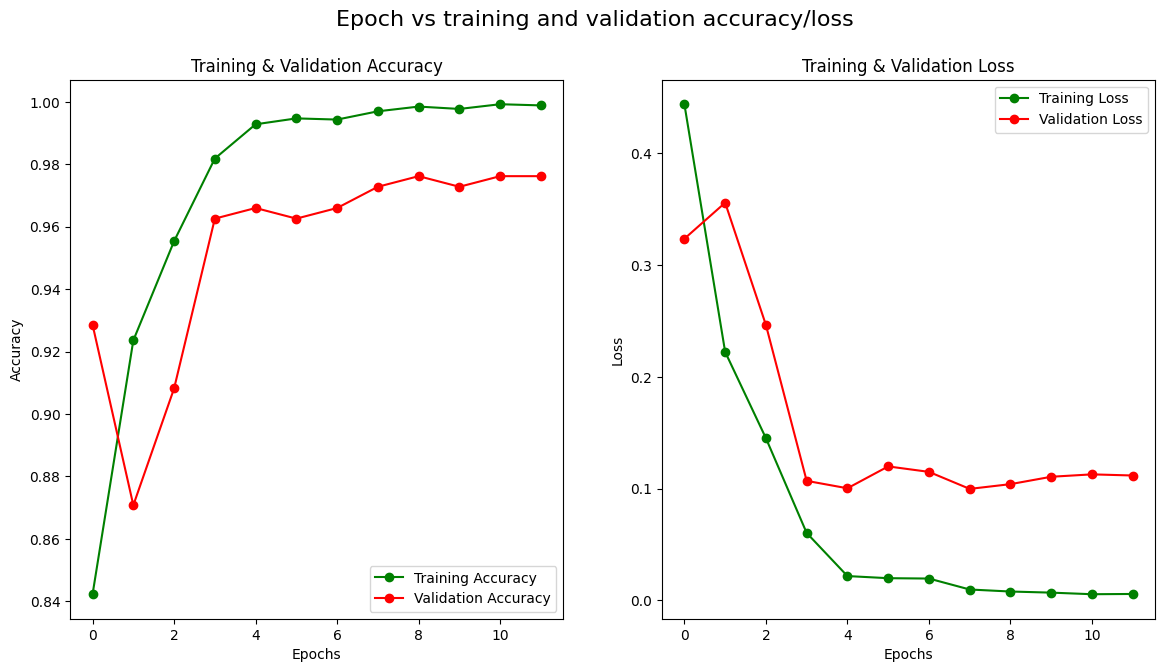

In [42]:
# Visualization epoch vs training and validation accuracy/loss
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2, figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.suptitle('Epoch vs training and validation accuracy/loss', size=16)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

fig.show()

## **Predicting on the test data**

In [43]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


**Classification report**

In [44]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        93
           1       0.98      1.00      0.99        51
           2       0.99      0.95      0.97        96
           3       0.99      1.00      0.99        87

    accuracy                           0.98       327
   macro avg       0.98      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327



**Confusion matrix**

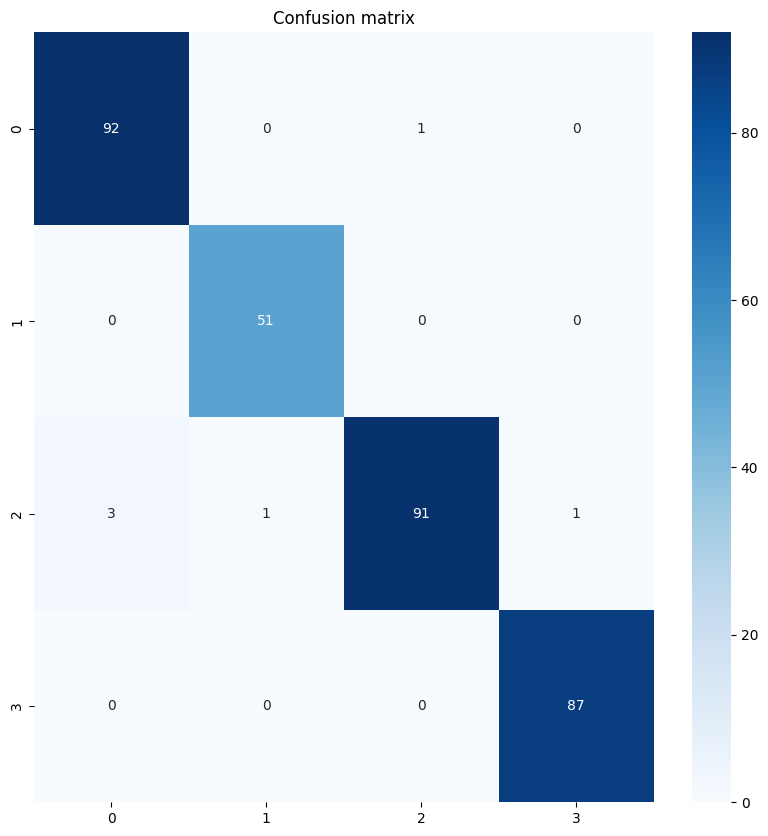

In [46]:
# Heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(confusion_matrix(y_test_new, pred), annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion matrix')

plt.show()

Confusion matrix insights:

* The model correctly identified 92 glioma_tumor cases (row 0, column 0).
* It correctly identified 51 no_tumor cases (row 1, column 1).
* It correctly identified 91 meningioma_tumor cases (row 2, column 2).
* It correctly identified 87 pituitary_tumor cases (row 3, column 3).

**Saving the trained models**

In [55]:
# Saving the trained models
model.save('/content/drive/MyDrive/Colab Notebooks/datasets/brain_tumor_dataset/brain_tumor_model_multiclass.h5')

## **Let's do some experiments**

Now, we want to conduct prediction experiment from uploaded photos to check the performance.

**Defining predictor function**

In [64]:
# Loader + multiclass predictor
import io
import cv2
import numpy as np
from PIL import Image

# label mapping
LABEL_MAP = {
    0: "Glioma Tumor",
    1: "No Tumor",
    2: "Meningioma Tumor",
    3: "Pituitary Tumor"
}

def load_uploaded_image_bytes(image_bytes):
    """Load image bytes -> OpenCV BGR -> resized (150x150) -> numpy array batch (1,H,W,3)."""
    pil_img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    # convert to OpenCV BGR
    opencvimage = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    # resize into proper image size
    img_resized = cv2.resize(opencvimage, (150, 150))  # image size 150
    img_batch = img_resized.reshape(1, 150, 150, 3)
    return img_batch, pil_img  # return batch for model and original PIL for display

def predict_image_multiclass(image_bytes):
    """Return predicted label (string). Assumes a multiclass model (softmax)."""
    img_batch, _ = load_uploaded_image_bytes(image_bytes)
    if 'model' not in globals():
        raise RuntimeError("Model not found. Load your Keras model into variable named `model` first.")
    preds = model.predict(img_batch)
    # multiclass: choose argmax
    if preds.ndim >= 2 and preds.shape[-1] > 1:
        idx = int(np.argmax(preds, axis=1)[0])
    else:
        # fallback for single-output models (binary)
        prob = float(preds[0][0])
        idx = 0 if prob > 0.5 else 1  # adapt if mapping differs
    return LABEL_MAP.get(idx, f"Class {idx}")


**First prediction with the Glioma tumor image**

Saving gliomatest.PNG to gliomatest (4).PNG


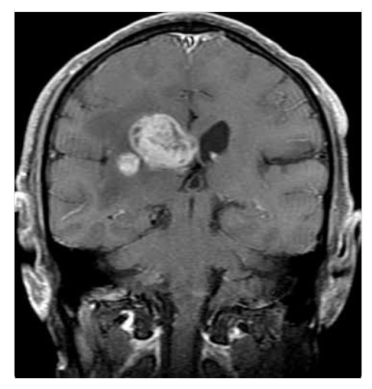

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
The model predicts: Glioma Tumor


In [65]:
# Upload, display uploaded image, and predict
# 1st prediction testing

from google.colab import files

# Upload image
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]

# Display uploaded image
img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict and print only the label
result = predict_image_multiclass(image_bytes)
if result == "No Tumor":
    print("The model predicts that there is no tumor")
else:
    print(f"The model predicts: {result}")


**Second prediction with no tumor image**

Saving testnotumour.jpg to testnotumour.jpg


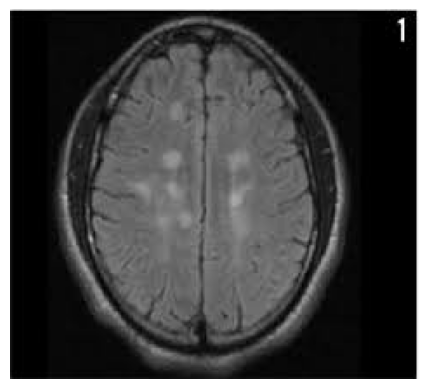

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
The model predicts that there is no tumor


In [66]:
# 2nd testing
# Upload new image with no tumour
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]

# Display uploaded image
img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict and print only the label
result = predict_image_multiclass(image_bytes)
if result == "No Tumor":
    print("The model predicts that there is no tumor")
else:
    print(f"The model predicts: {result}")

**Third prediction with the meningioma tumor image**

Saving testmeiningoma.jpg to testmeiningoma.jpg


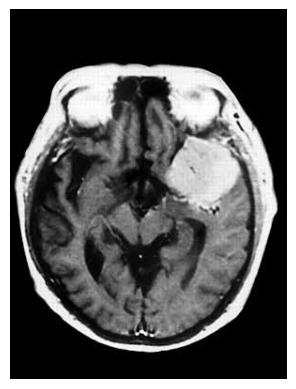

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
The model predicts: Meningioma Tumor


In [67]:
# 3rd testing
# Upload new image with meningioma tumor
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]

# Display uploaded image
img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict and print only the label
result = predict_image_multiclass(image_bytes)
if result == "No Tumor":
    print("The model predicts that there is no tumor")
else:
    print(f"The model predicts: {result}")

**Fourth prediction with the pituitary tumor image**

Saving testpituitari.jpg to testpituitari.jpg


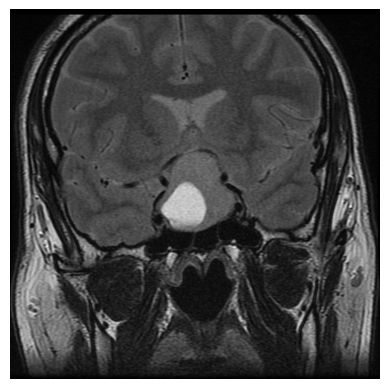

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
The model predicts: Pituitary Tumor


In [68]:
# 4th testing
# Upload new image with the pituitary_tumour
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]

# Display uploaded image
img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict and print only the label (
result = predict_image_multiclass(image_bytes)
if result == "No Tumor":
    print("The model predicts that there is no tumor")
else:
    print(f"The model predicts: {result}")

So far the result of predictions were correct. However, we can conduct more experiments to improve the model perfomance.